In [96]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
%matplotlib inline

### Let's use this example: classifying a song as either "rock" or "jazz". For this data we have measures of duration in seconds and loudness in loudness units (we're not going to be using decibels since that isn't a linear measure, which would create some problems we'll get into later).

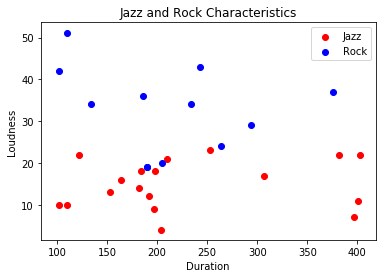

In [97]:
music = pd.DataFrame()

# Some data to play with.
music['duration'] = [184, 134, 243, 186, 122, 197, 294, 382, 102, 264, 
                     205, 110, 307, 110, 397, 153, 190, 192, 210, 403,
                     164, 198, 204, 253, 234, 190, 182, 401, 376, 102]
music['loudness'] = [18, 34, 43, 36, 22, 9, 29, 22, 10, 24, 
                     20, 10, 17, 51, 7, 13, 19, 12, 21, 22,
                     16, 18, 4, 23, 34, 19, 14, 11, 37, 42]

# We know whether the songs in our training data are jazz or not.
music['jazz'] = [ 1, 0, 0, 0, 1, 1, 0, 1, 1, 0,
                  0, 1, 1, 0, 1, 1, 0, 1, 1, 1,
                  1, 1, 1, 1, 0, 0, 1, 1, 0, 0]


# Look at our data.
plt.scatter(
    music[music['jazz'] == 1].duration,
    music[music['jazz'] == 1].loudness,
    color='red'
)
plt.scatter(
    music[music['jazz'] == 0].duration,
    music[music['jazz'] == 0].loudness,
    color='blue'
)
plt.legend(['Jazz', 'Rock'])
plt.title('Jazz and Rock Characteristics')
plt.xlabel('Duration')
plt.ylabel('Loudness')
plt.show()

The simplest form of a similarity model is the Nearest Neighbor model. This works quite simply: when trying to predict an observation, we find the closest (or _nearest_) known observation in our training data and use that value to make our prediction. Here we'll use the model as a classifier, the outcome of interest will be a category.

To find which observation is "nearest" we need some kind of way to measure distance. Typically we use _Euclidean distance_, the standard distance measure that you're familiar with from geometry. With one observation in n-dimensions $(x_1, x_2, ...,x_n)$ and the other $(w_1, w_2,...,w_n)$:

$$ \sqrt{(x_1-w_1)^2 + (x_2-w_2)^2+...+(x_n-w_n)^2} $$

You might recognize this formula, (taking distances, squaring them, adding the squares together, and taking the root) as a generalization of the [Pythagorean theorem](https://en.wikipedia.org/wiki/Pythagorean_theorem) into n-dimensions. You can technically define any distance measure you want, and there are times where this customization may be valuable. As a general standard, however, we'll use Euclidean distance.

Now that we have a distance measure from each point in our training data to the point we're trying to predict the model can find the datapoint with the smallest distance and then apply that category to our prediction.

Let's try running this model, using the SKLearn package.

In [98]:
from sklearn.neighbors import KNeighborsClassifier
neighbors = KNeighborsClassifier(n_neighbors=1)
X = music[['loudness', 'duration']]
Y = music.jazz
neighbors.fit(X,Y)

## Predict for a song with 24 loudness that's 190 seconds long.
neighbors.predict([[24, 190]])

array([0])

It's as simple as that. Looks like our model is predicting that 24 loudness, 190 second long song is _not_ jazz. All it takes to train the model is a dataframe of independent variables and a dataframe of dependent outcomes.

You'll note that for this example, we used the `KNeighborsClassifier` method from SKLearn. This is because Nearest Neighbor is a simplification of K-Nearest Neighbors. The jump, however, isn't that far.

## K-Nearest Neighbors

**K-Nearest Neighbors** (or "**KNN**") is the logical extension of Nearest Neighbor. Instead of looking at just the single nearest datapoint to predict an outcome, we look at several of the nearest neighbors, with $k$ representing the number of neighbors we choose to look at. Each of the $k$ neighbors gets to vote on what the predicted outcome should be.

This does a couple of valuable things. Firstly, it smooths out the predictions. If only one neighbor gets to influence the outcome, the model explicitly overfits to the training data. Any single outlier can create pockets of one category prediction surrounded by a sea of the other category.

This also means instead of just predicting classes, we get implicit probabilities. If each of the $k$ neighbors gets a vote on the outcome, then the probability of the test example being from any given class $i$ is:
$$ \frac{votes_i}{k} $$

And this applies for all classes present in the training set. Our example only has two classes, but this model can accommodate as many classes as the data set necessitates. To come up with a classifier prediction it simply takes the class for which that fraction is maximized.

Let's expand our initial nearest neighbors model from above to a KNN with a $k$ of 5.

In [99]:
neighbors = KNeighborsClassifier(n_neighbors=5)
X = music[['loudness', 'duration']]
Y = music.jazz
neighbors.fit(X,Y)

## Predict for a 24 loudness, 190 seconds long song.
print(neighbors.predict([[24, 190]]))
print(neighbors.predict_proba([[24, 190]]))

[1]
[[0.4 0.6]]


Now our test prediction has changed. In using the five nearest neighbors it appears that there were two votes for rock and three for jazz, so it was classified as a jazz song. This is different than our simpler Nearest Neighbors model. While the closest observation was in fact rock, there are more jazz songs in the nearest $k$ neighbors than rock.

We can visualize our decision bounds with something called a _mesh_. This allows us to generate a prediction over the whole space. Read the code below and make sure you can pull out what the individual lines do, consulting the documentation for unfamiliar methods if necessary.

In [118]:
np.c_[yy.ravel(), xx.ravel()]

array([[101.5,   3.5],
       [101.5,   4. ],
       [101.5,   4.5],
       ...,
       [403. ,  50. ],
       [403. ,  50.5],
       [403. ,  51. ]])

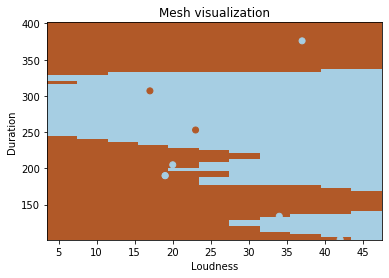

In [123]:
# Our data. Converting from data frames to arrays for the mesh.
X = np.array(X)
Y = np.array(Y)

# Mesh size.
h = 4.0

# Plot the decision boundary. We assign a color to each point in the mesh.
x_min = X[:, 0].min() - .5
x_max = X[:, 0].max() + .5
y_min = X[:, 1].min() - .5
y_max = X[:, 1].max() + .5
xx, yy = np.meshgrid(
    np.arange(x_min, x_max, h),
    np.arange(y_min, y_max, h)
)
Z = neighbors.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot.
Z = Z.reshape(xx.shape)
plt.figure(1, figsize=(6, 4))
plt.set_cmap(plt.cm.Paired)
plt.pcolormesh(xx, yy, Z)

# Add the training points to the plot.
plt.scatter(X[:, 0], X[:, 1], c=Y)
plt.xlabel('Loudness')
plt.ylabel('Duration')
plt.title('Mesh visualization')

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

plt.show()

Looking at the visualization above, any new point that fell within a blue area would be predicted to be jazz, and any point that fell within a brown area would be predicted to be rock.

The boundaries above are strangely jagged here, and we'll get into that in more detail in the next lesson.

Also note that the visualization isn't completely continuous. There are an infinite number of points in this space, and we can't calculate the value for each one. That's where the mesh comes in. We set our mesh size (`h = 4.0`) to 4.0 above, which means we calculate the value for each point in a grid where the points are spaced 4.0 away from each other.

You can make the mesh size smaller to get a more continuous visualization, but at the cost of a more computationally demanding calculation. In the cell below, recreate the plot above with a mesh size of `10.0`. Then reduce the mesh size until you get a plot that looks good but still renders in a reasonable amount of time. When do you get a visualization that looks acceptably continuous? When do you start to get a noticeable delay?

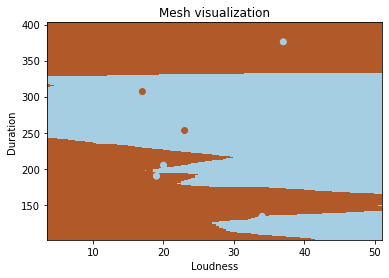

In [128]:
# Play with different mesh sizes here.
# Our data. Converting from data frames to arrays for the mesh.
X = np.array(X)
Y = np.array(Y)

# Mesh size.
h = 0.5

# Plot the decision boundary. We assign a color to each point in the mesh.
x_min = X[:, 0].min() - .5
x_max = X[:, 0].max() + .5
y_min = X[:, 1].min() - .5
y_max = X[:, 1].max() + .5
xx, yy = np.meshgrid(
    np.arange(x_min, x_max, h),
    np.arange(y_min, y_max, h)
)
Z = neighbors.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot.
Z = Z.reshape(xx.shape)
plt.figure(1, figsize=(6, 4))
plt.set_cmap(plt.cm.Paired)
plt.pcolormesh(xx, yy, Z)

# Add the training points to the plot.
plt.scatter(X[:, 0], X[:, 1], c=Y)
plt.xlabel('Loudness')
plt.ylabel('Duration')
plt.title('Mesh visualization')

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

plt.show()


> ### At h = 0.25, you get a noticeable delay, but not prohibitively long. The image is fairly continuous although not significantly more continuous than at h = 0.5, a mesh size with little delay in visualization rendering time. At h= 0.05, the delay is prohibitively long.

In [104]:
# My nearest neighbor algorithm (X = features, Y = target, n = k_neighbors)
def knn(X, Y, n):
    neighbors = {}
    value = 0
    x, y = input("Enter your 'loudness' value followed by you 'duration' value, separated by a space:").split()
    for i in range(len(X)):
        neighbors[np.sqrt((int(x) - X[i][0])**2 + (int(y) - X[i][1])**2)] = Y[i]
    key_list = sorted(list(neighbors.keys()))
    for i in key_list[:n]:
        value += neighbors[i]
    if value/n >= .5:
        print("*** Prediction: Jazz ***")
    else:
        print("*** Prediction: Rock ***")
    print(f'Jazz votes/%: {value}/{value/n * 100}%\nRock votes/%: {n - value}/{(1 - value/n) * 100}%')

In [105]:
knn(X,Y,5)

Enter your 'loudness' value followed by you 'duration' value, separated by a space:100 100
*** Prediction: Rock ***
Jazz votes/%: 2/40.0%
Rock votes/%: 3/60.0%


# Tuning KNN: Normalization
We've talked about the distance measure we use for deciding how close other observations are to a test point, but when we did so we glossed over some important nuance in measuring distance. Specifically, the measurement makes the assumption that all units are equal. So, in our previous example, being 1 loudness unit away is equivalent to being 1 second away. This is intensely problematic and one of the main issues people have with KNN. Units are rarely equivalent, and discerning how to adjust that unequivalence is an abstract and touchy subject. This difficulty also makes binary or categorical variables nearly impossible to include in a KNN model. It really is best if they are continuous.

**Normalization** is a way of taking these seemingly incommensurate measures and making them comparable. There are two main normalization techniques that are effective with KNN.

1. You can set the bounds of the data to 0 and 1, and then **rescale** every variable to be within those bounds (it may also be reasonable to do -1 to 1, but the difference is actually immaterial). <font color='blue'>This way every data point is measured in terms of its distance between the max and minimum of its category.</font> This is best if the data shows a linear relationship, such that scaling to a 0 to 1 range makes logical sense. It is also best if there are known limits to the dataset, as those make for logical bounds for 0 and 1 for the rescaling.

2. You can also calculate how far each observation is from the mean, expressed in number of standard deviations: this is often called **z-scores**. <font color='red'>Calculating z-scores and using them as your basis for measuring distance works for continuous data and puts everything in terms of how far from the mean (or "abnormal") it is.</font>

# #1 Max-min Normalization

In [204]:
neighbors = KNeighborsClassifier(n_neighbors=5)
X = music[['loudness', 'duration']]
Y = music.jazz

X_max_min = {
             'loudness': (X.loudness - X.loudness.min())/(X.loudness.max() - X.loudness.min()),
             'duration': (X.duration - X.duration.min())/(X.duration.max() - X.duration.min()),
            }
X_max_min = pd.DataFrame(X_max_min)

neighbors.fit(X_max_min,Y)

## Predict for a 24 loudness, 190 seconds long song.
print(neighbors.predict([[24, 190]]))
print(neighbors.predict_proba([[24, 190]]))

[1]
[[0.2 0.8]]


> ### In using the five nearest max/min normalized neighbors, it appears that there was one vote for rock and four for jazz, so it was classified as a jazz song. Now let's see what the mesh diagram for max/min normalized data points looks like.

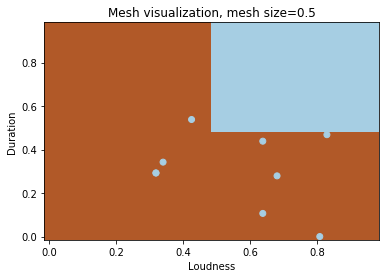

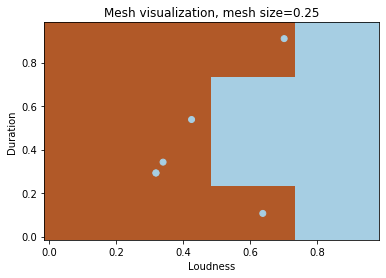

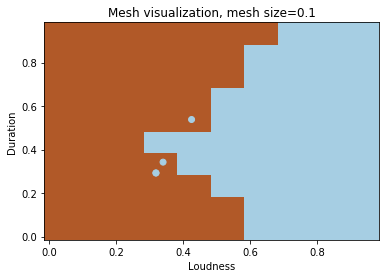

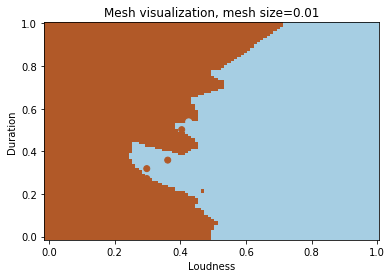

In [205]:
# Our data. Converting from data frames to arrays for the mesh.
X = np.array(X_max_min)
Y = np.array(Y)

for num in [0.5, 0.25, 0.1, 0.01]:
    # Mesh size.
    h = num

    # Plot the decision boundary (Note different boundaries from revious example).
    # We choose 0.015 because it falls halfway between each percentage point of the observations
    # We assign a color to each point in the mesh.
    x_min = X[:, 0].min() - 0.015
    x_max = X[:, 0].max() + 0.015
    y_min = X[:, 1].min() - 0.015
    y_max = X[:, 1].max() + 0.015
    xx, yy = np.meshgrid(
        np.arange(x_min, x_max, h),
        np.arange(y_min, y_max, h)
    )
    Z = neighbors.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot.
    Z = Z.reshape(xx.shape)
    plt.figure(1, figsize=(6, 4))
    plt.set_cmap(plt.cm.Paired)
    plt.pcolormesh(xx, yy, Z)

    # Add the training points to the plot.
    plt.scatter(X[:, 0], X[:, 1], c=Y)
    plt.xlabel('Loudness')
    plt.ylabel('Duration')
    plt.title(f'Mesh visualization, mesh size={h}')

    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

    plt.show()

> ### The delineation between classification regions is a lot more straightforward than with the raw data, at every mesh size.

# #2 Z-score Normalization

In [206]:
neighbors = KNeighborsClassifier(n_neighbors=5)
X = music[['loudness', 'duration']]
Y = music.jazz

X_zscore = {
             'loudness': (X.loudness - X.loudness.mean())/np.std(X.loudness),
             'duration': (X.duration - X.duration.mean())/np.std(X.duration),
            }
X_zscore = pd.DataFrame(X_zscore)

neighbors.fit(X_zscore,Y)

## Predict for a 24 loudness, 190 seconds long song.
print(neighbors.predict([[24, 190]]))
print(neighbors.predict_proba([[24, 190]]))

[1]
[[0.2 0.8]]


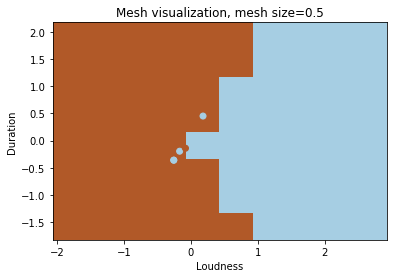

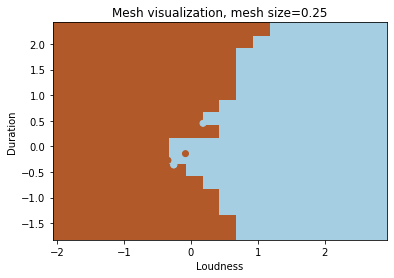

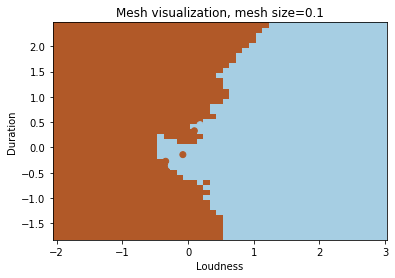

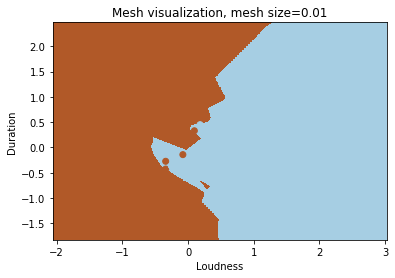

In [207]:
# Our data. Converting from data frames to arrays for the mesh.
X = np.array(X_zscore)
Y = np.array(Y)

for num in [0.5, 0.25, 0.1, 0.01]:
    # Mesh size.
    h = num

    # Plot the decision boundary (Note different boundaries from revious examples).
    # We choose 0.5 because it falls halfway between each z-score of the observations
    # We assign a color to each point in the mesh.
    x_min = X[:, 0].min() - .5
    x_max = X[:, 0].max() + .5
    y_min = X[:, 1].min() - .5
    y_max = X[:, 1].max() + .5
    xx, yy = np.meshgrid(
        np.arange(x_min, x_max, h),
        np.arange(y_min, y_max, h)
    )
    Z = neighbors.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot.
    Z = Z.reshape(xx.shape)
    plt.figure(1, figsize=(6, 4))
    plt.set_cmap(plt.cm.Paired)
    plt.pcolormesh(xx, yy, Z)

    # Add the training points to the plot.
    plt.scatter(X[:, 0], X[:, 1], c=Y)
    plt.xlabel('Loudness')
    plt.ylabel('Duration')
    plt.title(f'Mesh visualization, mesh size={h}')

    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

    plt.show()

> ### Once again, the delineation between classification regions is a lot more straightforward than with the raw data.

# Weighting

There is one more thing to address when talking about distance, and that is **weighting**. In the vanilla version of KNN, all $k$ of the closest observations are given equal votes on what the outcome of our test observation should be. When the data is densely populated that isn't necessarily a problem. Particularly if there is variance in the measurement itself, not trying to draw information from small differences in distance can be wise.

However, sometimes the $k$ nearest observations are not all similarly close to the test. In that case it may be useful to weight by distance. Functionally this will weight by the inverse of distance, so that closer datapoints (with a low distance) have a higher weight than further ones.

SKLearn again makes this quite easy to implement. There is an optional weights parameter that can be used when defining the model. Set that parameter to "distance" and you will use distance weighting.

Let's try it below and see how it affects our model. You can also use the stats module from SciPy to convert our data to z-scores.

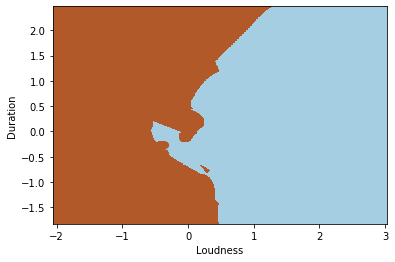

In [224]:
neighbors = KNeighborsClassifier(n_neighbors=5, weights='distance')
X = music[['loudness', 'duration']]
Y = music.jazz

X_zscore = {
             'loudness': (X.loudness - X.loudness.mean())/np.std(X.loudness),
             'duration': (X.duration - X.duration.mean())/np.std(X.duration),
            }
X_zscore = pd.DataFrame(X_zscore)

neighbors.fit(X_zscore,Y)

# Fit our model.
neighbors.fit(X_zscore, Y)

# Arrays, not data frames, for the mesh.
X = np.array(X_zscore)
Y = np.array(Y)

# Mesh size.
h = .01

# Plot the decision boundary. We assign a color to each point in the mesh.
x_min = X[:,0].min() - .5
x_max = X[:,0].max() + .5
y_min = X[:,1].min() - .5
y_max = X[:,1].max() + .5
xx, yy = np.meshgrid(
    np.arange(x_min, x_max, h),
    np.arange(y_min, y_max, h)
)
Z = neighbors.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1, figsize=(6, 4))
plt.set_cmap(plt.cm.Paired)
plt.pcolormesh(xx, yy, Z)

# Add the training points to the plot.
plt.scatter(X[:, 0], X[:, 1], c=Y)
plt.xlabel('Loudness')
plt.ylabel('Duration')

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

plt.show()

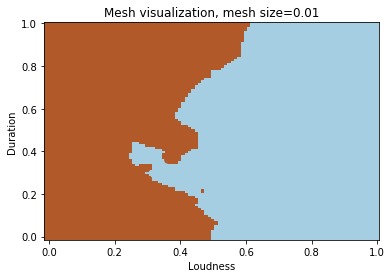

In [226]:
neighbors = KNeighborsClassifier(n_neighbors=5, weights='distance')
X = music[['loudness', 'duration']]
Y = music.jazz

X_max_min = {
             'loudness': (X.loudness - X.loudness.min())/(X.loudness.max() - X.loudness.min()),
             'duration': (X.duration - X.duration.min())/(X.duration.max() - X.duration.min()),
            }
X_max_min = pd.DataFrame(X_max_min)

neighbors.fit(X_max_min,Y)

# Arrays, not data frames, for the mesh.
X = np.array(X_max_min)
Y = np.array(Y)

# Mesh size.
h = .01

# Plot the decision boundary (Note different boundaries from revious example).
# We choose 0.015 because it falls halfway between each percentage point of the observations
# We assign a color to each point in the mesh.
x_min = X[:, 0].min() - 0.015
x_max = X[:, 0].max() + 0.015
y_min = X[:, 1].min() - 0.015
y_max = X[:, 1].max() + 0.015
xx, yy = np.meshgrid(
    np.arange(x_min, x_max, h),
    np.arange(y_min, y_max, h)
)
Z = neighbors.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot.
Z = Z.reshape(xx.shape)
plt.figure(1, figsize=(6, 4))
plt.set_cmap(plt.cm.Paired)
plt.pcolormesh(xx, yy, Z)

# Add the training points to the plot.
plt.scatter(X[:, 0], X[:, 1], c=Y)
plt.xlabel('Loudness')
plt.ylabel('Duration')
plt.title(f'Mesh visualization, mesh size={h}')

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

plt.show()

> ### In all the mesh grids, z-score normalization creates a more copntinuous delineation than max/min normaloization (ie. less pixelated and more detailed at each mesh size)